# Convolutional Neural Networks (CNN)

Convolutional neural networks (CNNs) are a class of neural networks that have convolutional layers.

CNNs are particularly effective for data that have spatial structures and correlations (e.g. images).

Multilayer perceptrons (MLP) are entirely composed of fully connected layers, which are each a matrix multiply operation (and addition of a bias) followed by a non-linearity (e.g. sigmoid, ReLU). 
A convolutional layer is similar, except the matrix multiply operation is replaced with a convolution operation (in practice a cross-correlation). 
Note that a CNN need not be entirely composed of convolutional layers; in fact, many popular CNN architectures end in fully connected layers.

### Representing images digitally

Images are represented as a $H \times W$ table, with the value of each element storing the intensity of the corresponding pixel.

However, this can only efficiently represent greyscale images. If we want color, we can use the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model).

3 tables of pixel intensities (channel) is stored, 1 for each channel Red, Green, Blue, which gives a $H \times W \times 3$ tensor. Pixel values for a particular channel indicate how much of the corresponding color the image has at a particular location:

C:\Users\tristan\AppData\Local\Temp\ipykernel_19468\4175376912.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread("./resources/chapel.jpg")


Shape of the image tensor: (620, 1175, 3)


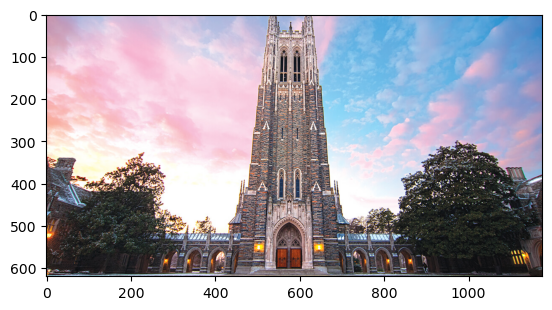

In [2]:
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

# Read image
im = imageio.imread("./resources/chapel.jpg")
print("Shape of the image tensor: {}".format(im.shape))
plt.imshow(im)

The image loaded above has height and width of $620 \times 1175$, with 3 channels corresponding to RGB.

We can then slice out and view individual color channels:

(620, 1175)


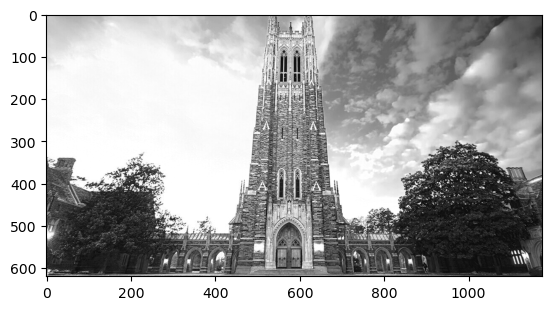

In [3]:
# Red channel
im_red = im[:,:,0]
print(im_red.shape)
plt.imshow(im_red, cmap='gray')

(620, 1175)


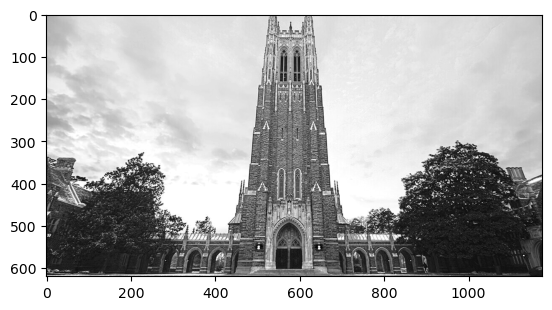

In [7]:
# Blue channel
im_blue = im[:,:,2]
print(im_blue.shape)
plt.imshow(im_blue, cmap='gray')

There might also be scenarios where you consider a different number of channels. For example [hyperspectral imaging](https://en.wikipedia.org/wiki/Hyperspectral_imaging) uses a wide range of the electromagnetic spectrum to characterize a scene.

Certain intermediate representations in a CNN can be considered images with many channels.

### Convolutions

#### Fully Connected Layer

In a fully connected layer, the input $x \in \mathbb R^{M \times C_{in}}$ is a vector (or, rather a batch of vectors), where $M$ is the minibatch size and $C_{in}$ is the dimensionality of the input. 
We first matrix multiply the input $x$ by a weight matrix $W$.
This weight matrix has dimensions $W \in \mathbb R^{C_{in} \times C_{out}}$, where $C_{out}$ is the number of output units.
We then add a bias for each output, which we do by adding $b \in \mathbb{R}^{C_{out}}$.
The output $y \in \mathbb{R}^{M \times C_{out}}$ of the fully connected layer then:

\begin{align*}
y = \text{ReLU}(x W + b)
\end{align*}

The values of $W$ and $b$ are variables that we are trying to learn for our model. 
Below we have a visualization of what the matrix operation looks like (bias term and activation function omitted).

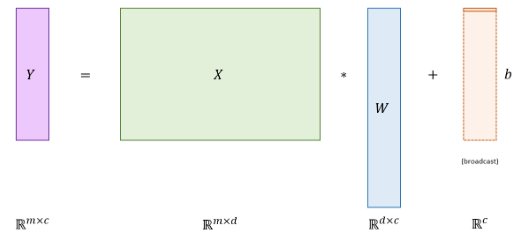

In [8]:
import numpy as np
import torch
import torch.nn.functional as F

# Create a random flat input vector
x_fc = torch.randn(100, 784)

# Create weight matrix variable
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Create bias variable
b = torch.zeros(10, requires_grad=True)

# Apply fully connected layer
y_preact = torch.matmul(x_fc, W) + b
y = F.relu(y_preact)

# Print input/output shape
print("Input shape: {}".format(x_fc.shape))
print("Output shape: {}".format(y.shape))

Input shape: torch.Size([100, 784])
Output shape: torch.Size([100, 10])


#### Convolutional Layer

In a convolutional layer, we convolve the input $x$ with a convolutional kernel (aka filter), which we also call $W$, producing output $y$:

\begin{align*}
y = \text{ReLU}(W*x + b)
\end{align*}

In the context of CNNs, the output $y$ is often referred to as feature maps. As with a fully connected layer, the goal is to learn $W$ and $b$ for our model.

Unlike the input of a fully connected layer, which is $x \in \mathbb R^{M\times C_{in}}$, the dimensionality of an image input is 4D: $x \in \mathbb R^{M \times C_{in} \times H_{in} \times W_{in}}$, where $M$ is still the batch size, $C_{in}$ is the number of channels of the input (e.g. 3 for RGB), and $H_{in}$ and $W_{in}$ are the height and width of the image.

The weight parameter $W$ is also different in a convolutional layer.
Unlike the 2-D weight matrix for fully connected layers, the kernel is 4-D with dimensions $W \in \mathbb R^{C_{out} \times C_{in} \times H_K \times W_K }$, where $H_K$ and $W_K$ are the kernel height and weight, respectively.
A common choice for $H_K$ and $W_K$ is $H_K = W_K = 3$ or $5$, but this tends to vary depending on the architecture.
Convolving the input with the kernel and adding a bias then gives an output $y \in \mathbb R^{M \times C_{out} \times H_{out} \times W_{out}}$.
If we use "same" padding and a stride of $1$ in our convolution (more on this later), our output will have the same spatial dimensions as the input: $H_{out}=H_{in}$ and $W_{out}=W_{in}$.

If you're having trouble visualizing this operation in 4D, it's easier to think about for a single member of the minibatch, one convolutional kernel at a time. 
Consider a stack of $C_{out}$ number of kernels, each of which are 3D ($C_{in} \times H_K \times W_K $). 
This 3D volume is then slid across the input (which is also 3D: $C_{in} \times H_{in} \times W_{in}$) in the two spatial dimensions (along $H_{in}$ and $W_{in}$). 
The outputs of the multiplication of the kernel and the input at every location creates a single feature map that is $H_{out} \times W_{out}$. 
Stacking the feature maps generated by each kernel gives the 3D output $C_{out} \times H_{out} \times W_{out} $.
Repeat the process for all $M$ inputs in the minibatch, and we get a 4D output $M  \times C_{out} \times H_{out} \times W_{out}$.

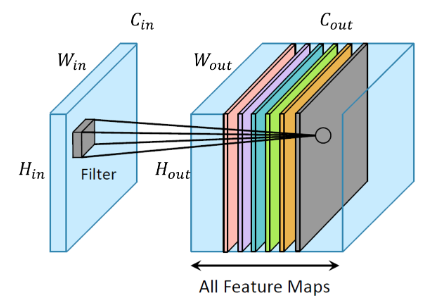

A few more things to note:
- Notice the ordering of the dimensions of the input (batch, channels in, height, width).
This is commonly referred to as $NCHW$ ordering.
Many other languages and libraries (e.g. MATLAB, TensorFlow, the image example at the beginning of this notebook) instead default to the slightly different $NHWC$ ordering.
PyTorch defaults to $NCHW$, as it is more efficient computationally, especially with CUDA. 
- An additional argument for the convolution is the *stride*, which controls the how far we slide the convolutional filter as we move it along the input image. 
The convolutional operator, from its signal processing roots, by default considers a stride length of 1 in all dimensions, but in some situations we would like to consider strides more than 1 (or even less than 1). 
More on this later.
- In the context of signal processing, convolutions usually result in outputs that are larger than the input size, which results from when the kernel "hangs off the edge" of the input on both sides. 
This might not always be desirable.
We can control this by controlling the padding of the input.
Typically, we use pad the input to ensure the output has the same spatial dimensions as the input (assuming stride of 1); this makes it easier for us to keep track of what the size of our model is.

Let's implement this convolution operator in code.
There is a convolution implementation in `torch.nn.functional`, which we use here.

In [9]:
# Create a random image input tensor
x_cnn = torch.randn(100, 1, 28, 28)

# Create convolutional kernel variable
W1 = torch.randn(16, 1, 3, 3)/np.sqrt(1*3*3) # 16 filters, 1 input channel, 3x3 size
W1.requires_grad_()

# Create bias variable
b1 = torch.zeros(16, requires_grad=True) # 16 filters

# Apply convolutional layer
conv1_preact = F.conv2d(x_cnn, W1, bias=b1, stride=1, padding=1)
conv1 = F.relu(conv1_preact)

# Print input/output shape
print("Input shape: {}".format(x_cnn.shape))
print("Convolution output shape: {}".format(conv1.shape))

Input shape: torch.Size([100, 1, 28, 28])
Convolution output shape: torch.Size([100, 16, 28, 28])


Just like in a MLP, we can stack multiple of these convolutional layers. 
In the *Representing Images Digitally* section, we briefly mentioned considering images with channels more than 3.
Observe that the input to the second layer (i.e. the output of the first layer) can be viewed as an "image" with $C_{out}$ channels.
Instead of each channel representing a color content though, each channel effectively represents how much the original input image activated a particular convolutional kernel.
Given $C_{out}$ kernels that are each $C_{in} \times H_K \times W_K$, this results in $C_{out}$ channels for the output of the convolution.

Note that we need to change the dimensions of the convolutional kernel such that its input channels matches the number of output channels of the previous layer:

In [11]:
# 2nd layer variables
W2 = torch.randn(32, 16, 3, 3)/np.sqrt(16*3*3) # 32 filters, 16 input channels, 3x3 size
# notice that the number of input channels must match the number of filters in the previous layer
W2.requires_grad_()
b2 = torch.zeros(32, requires_grad=True) # 32 filters

# Apply 2nd convolutional layer
conv2 = F.relu(F.conv2d(conv1, W2, bias=b2, stride=1, padding=1))

# Print output shape
print("Second convolution output shape: {}".format(conv2.shape))

Second convolution output shape: torch.Size([100, 32, 28, 28])


#### Reshaping

Use PyTorch `view()` to reshape tensors, akin to NumPy's `np.reshape()`.

New dimensions must be chosen so that it is possible to rearrange the input into the shape of the output (i.e. the total number of elements must be the same).
As with NumPy, you can optionally replace one of the dimensions with a `-1`, which tells `torch` to infer the missing dimension.

In [12]:
M = torch.zeros(4, 3)

M2 = M.view(1,1,12)
M3 = M.view(2,1,2,3)
M4 = M.view(-1,2,3)
M5 = M.view(-1)

CNN expects 4D input and the data might not come in this format, so reshaping is necessary.

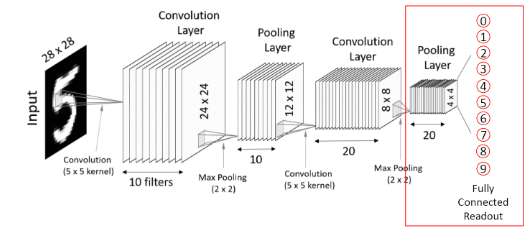

In [13]:
# Reshape flat input image into a 4D batched image input
x_flat = torch.randn(100, 784)
x_reshaped = x_flat.view(-1, 1, 28, 28)

# Print input shape
print(x_reshaped.shape)

torch.Size([100, 1, 28, 28])


CNN architectures also commonly contain fully connected layers or a softmax, as we're often interested in classification.
Both of these expect 2D inputs with dimensions `[batch, dim]`, so you have to "flatten" a CNN's 4D output to 2D.
For example, to flatten the convolutional feature maps we created earlier:

In [14]:
# Flatten convolutional feature maps into a vector
h_flat = conv2.view(-1, 28*28*32)

# Print output shape
print(h_flat.shape)

torch.Size([100, 25088])


### Pooling and Striding

Almost all CNN architectures incorporate either pooling or striding. This is done for a number of reasons, including:
- Dimensionality reduction: pooling and striding operations reduces computational complexity by shrinking the number of values passed to the next layer.
For example, a 2x2 maxpool reduces the size of the feature maps by a factor of 4.
- Translational invariance: Oftentimes in computer vision, we'd prefer that shifting the input by a few pixels doesn't change the output. Pooling and striding reduces sensitivity to exact pixel locations.
- Increasing receptive field: by summarizing a window with a single value, subsequent convolutional kernels are seeing a wider swath of the original input image. For example, a max pool on some input followed by a 3x3 convolution results in a kernel "seeing" a 6x6 region instead of 3x3.

#### Pooling
The two most common forms of pooling are max pooling and average pooling. 
Both reduce values within a window to a single value, on a per-feature-map basis.
Max pooling takes the maximum value of the window as the output value; average pooling takes the mean.

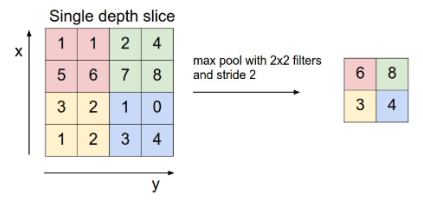

In [16]:
# Taking the output we've been working with so far, first print its current size
print("Shape of conv2 feature maps before pooling: {0}".format(conv2.shape))

# Max pool and then print new shape
max_pool2 = F.max_pool2d(conv2, kernel_size=2)
print("Shape of conv2 feature maps after max pooling: {0}".format(max_pool2.shape))

# Average pool and then print new shape
avg_pool2 = F.avg_pool2d(conv2, kernel_size=2)
print("Shape of conv2 feature maps after avg pooling: {0}".format(avg_pool2.shape))

# Recreate values in pooling figure and make it 4D
feature_map_fig = torch.tensor(np.array([[1,1,2,4],
                                        [5,6,7,8],
                                        [3,2,1,0],
                                        [1,2,3,4]], dtype=np.float32))
fmap_fig = feature_map_fig.view(1,1,4,4)
print("Feature map shape pre-pooling: {}".format(fmap_fig.shape))

# Maxpool
max_pool_fig = F.max_pool2d(fmap_fig, kernel_size=2)
print("\nMax pool")
print("Shape: {}".format(max_pool_fig.shape))
print(torch.squeeze(max_pool_fig))

# Avgpool
avg_pool_fig = F.avg_pool2d(fmap_fig, kernel_size=2)
print("\nAvg pool")
print("Shape: {}".format(avg_pool_fig.shape))
print(torch.squeeze(avg_pool_fig))

Shape of conv2 feature maps before pooling: torch.Size([100, 32, 28, 28])
Shape of conv2 feature maps after max pooling: torch.Size([100, 32, 14, 14])
Shape of conv2 feature maps after avg pooling: torch.Size([100, 32, 14, 14])
Feature map shape pre-pooling: torch.Size([1, 1, 4, 4])

Max pool
Shape: torch.Size([1, 1, 2, 2])
tensor([[6., 8.],
        [3., 4.]])

Avg pool
Shape: torch.Size([1, 1, 2, 2])
tensor([[3.2500, 5.2500],
        [2.0000, 2.0000]])


#### Striding

One might expect that pixels in an image have high correlation with neighboring pixels, so we can save computation by skipping positions while sliding the convolutional kernel. 
By default, a CNN slides across the input one pixel at a time, which we call a stride of 1.
By instead striding by 2, we skip calculating 75% of the values of the output feature map, which yields a feature map that's half the size in each spatial direction.
Note, while pooling is an operation done after the convolution, striding is part of the convolution operation itself.

In [17]:
# Since striding is part of the convolution operation, we'll start with the feature maps before the 2nd convolution
print("Shape of conv1 feature maps: {0}".format(conv1.shape))

# Apply 2nd convolutional layer, with striding of 2
conv2_strided = F.relu(F.conv2d(conv1, W2, bias=b2, stride=2, padding=1))

# Print output shape
print("Shape of conv2 feature maps with stride of 2: {0}".format(conv2_strided.shape))

Shape of conv1 feature maps: torch.Size([100, 16, 28, 28])
Shape of conv2 feature maps with stride of 2: torch.Size([100, 32, 14, 14])


### Building a simple CNN (MNIST)

Use the following CNN as our classifier: $5 \times 5$ convolution -> $2 \times 2$ max pool -> $5 \times 5$ convolution -> $2 \times 2$ max pool -> fully connected to $\mathbb R^{256}$ -> fully connected to $\mathbb R^{10}$ (prediction). 
ReLU activation functions will be used to impose non-linearities.
Remember, convolutions produce 4-D outputs, and fully connected layers expect 2-D inputs, so tensors must be reshaped when transitioning from one to the other.

We can build this CNN with the components introduced before, but as with the logistic regression example, it may prove helpful to instead organize our model with a `nn.Module`.

* Formula to calculate output size after convolutional layer:

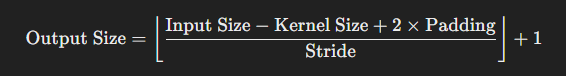

* The formula to calculate the output size after a max pooling layer is:

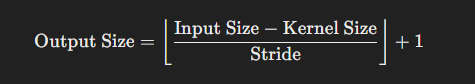


In [20]:
import torch.nn as nn

class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7*7*64, 256) # 7*7*64 chosen because of the size of the feature maps after the 2nd conv
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # fc layer 1
        x = x.view(-1, 7*7*64) # reshape 4D tensor into 2D tensor to be fed into fc layer
        x = self.fc1(x)
        x = F.relu(x)
        
        # fc layer 2
        x = self.fc2(x)
        return x        
    
# The code for submodule initialization, which creates all the stateful parameters associated with each operation, is placed in the __init__() function, where it is run once during object instantiation.
# The code describing the forward pass, which is used every time the model is run, is placed in the forward() method.
model = MNIST_CNN()
print(model)

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


We use this new model in the logistic regression code:

* Note on [Adam](https://arxiv.org/abs/1412.6980) optimizer

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model  
model = MNIST_CNN()  # <---- change here

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # <---- change here - use Adam Optimizer instead of stochastic gradient descent

# Iterate through train set minibatchs 
for epoch in trange(3):  # <---- change here - 3 epochs instead of 1
    for images, labels in tqdm(train_loader):
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        x = images  # <---- change here - do not need to flatten the input
        y = model(x)
        loss = criterion(y, labels)
        # Backward pass
        loss.backward()
        optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images  # <---- change here - do not need to flatten the input
        y = model(x)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9890000224113464


### Torchvision

#### Datasets and Transforms

Often, we have to write significant code to handle downloading, organizing, formatting, shuffling, pre-processing, augmenting, and batching examples. 
For popular datasets, we'd like to standardize data handling so that the comparisons we make are specific to the models themselves.

[Torchvision](https://pytorch.org/docs/stable/torchvision/index.html) includes easy-to-use APIs for downloading and loading many popular vision datasets.

Currently, [datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) for image classification (e.g. MNIST, CIFAR, ImageNet), object detection (VOC, COCO, Cityscapes), and video action recognition (UCF101, Kinetics) are included.

For formatting, pre-processing, and augmenting, use [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html).
Other than using it to convert PIL images to tensors, it can also be used for 
preprocessing steps like data whitening before feeding the data into the model, or data augmentations to artificially inflate our dataset and learn invariances.

#### Using other CNNs

[List of supported CNNs](https://pytorch.org/docs/stable/torchvision/models.html)

Why?
- For image datasets larger and more complex than MNIST (which is basically all of them), a fair amount network depth and width is often necessary.
- Popular CNNs can be over 100 layers deep, with several tricks and details beyond what we've covered in this notebook. Coding all of this yourself has a high potential for error.
- Ability to use pre-trained weights for transfer learning capabilities

[Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) for using pre-trained CNNs.

In [ ]:
import torchvision.models as models

resnet18 = models.resnet18()
print(resnet18)

# to load pretrained model
resnet18_trained = models.resnet18(pretrained=True)

#### Other computer vision tasks

Torchvision contains a few models (and pre-trained weights) for object detection, segmentation, and video action recognition.

However, Torchvision's selection of non-classification models is relatively light, and not particularly flexible.
A number of other libraries are available, depending on the task.
For example, for object detection and segmentation, Facebook AI Research's [Detectron2](https://github.com/facebookresearch/detectron2) is highly recommend.

For example, to load a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a [ResNet50](https://arxiv.org/abs/1512.03385) convolutional feature extractor with [Feature Pyramid Networks](https://arxiv.org/abs/1612.03144) pre-trained on [MS COCO](http://cocodataset.org/#home):

In [23]:
object_detector = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\tristan/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
  4%|▍         | 7.00M/160M [00:00<00:18, 8.86MB/s]


KeyboardInterrupt: 

### CNN Full Code for MNIST

Implemented LR Scheduler + Early Stopping + Training on Train & Validation sets

Image ->  
convolution (32 3x3 filters) -> nonlinearity (ReLU) ->  
convolution (32 3x3 filters) -> nonlinearity (ReLU) -> (2x2 max pool) ->  
convolution (64 3x3 filters) -> nonlinearity (ReLU) ->  
convolution (64 3x3 filters) -> nonlinearity (ReLU) -> (2x2 max pool) -> flatten ->
fully connected (256 hidden units) -> nonlinearity (ReLU) ->  
fully connected (10 hidden units) -> softmax 

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from torch.utils.data import SubsetRandomSampler

transform = transforms.ToTensor()

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

# Create training and validation sets
num_train = len(mnist_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(0.8 * num_train)  # 80% for training, 20% for validation
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(7*7*64, 256) # 7*7*64 chosen because of the size of the feature maps after the 2nd conv
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        
        # conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        
        # conv layer 4
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # fc layer 1
        x = x.view(-1, 7*7*64) # reshape 4D tensor into 2D tensor to be fed into fc layer
        x = self.fc1(x)
        x = F.relu(x)
        
        # fc layer 2
        x = self.fc2(x)
        return x 

## Training
# Instantiate model  
model = MNIST_CNN() 

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) ## Learning rate scheduler

# Set the number of epochs and early stopping criteria
num_epochs = 10
patience = 2
best_val_loss = float('inf')
early_stop_counter = 0
final_num_epoch = 0

# Iterate through train set minibatchs 
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        x = images  
        y = model(x)
        loss = criterion(y, labels)
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    scheduler.step()  # Adjust the learning rate
    
    average_train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {average_train_loss:.4f}')
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = len(mnist_test)
    with torch.no_grad():
        for images, labels in val_loader:
            # Forward pass
            x = images
            y = model(x)
            val_loss += criterion(y, labels).item()
            predictions = torch.argmax(y, dim=1)
            correct += torch.sum((predictions == labels).float())
    
    val_loss /= len(test_loader)
    accuracy = correct / total
    
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Test accuracy: {accuracy:.4f}, Learning rate: {scheduler.get_last_lr()[0]}')
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        final_num_epoch = epoch+1
        break

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images 
        y = model(x)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print('Test accuracy: {}'.format(correct/total))

Epoch 1/10:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.2087
Epoch 1/10, Validation Loss: 0.0742, Test accuracy: 1.1777, Learning rate: 0.001


Epoch 2/10:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 2/10, Training Loss: 0.0492
Epoch 2/10, Validation Loss: 0.0568, Test accuracy: 1.1820, Learning rate: 0.001


Epoch 3/10:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 3/10, Training Loss: 0.0333
Epoch 3/10, Validation Loss: 0.0532, Test accuracy: 1.1847, Learning rate: 0.001


Epoch 4/10:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 4/10, Training Loss: 0.0233
Epoch 4/10, Validation Loss: 0.0475, Test accuracy: 1.1860, Learning rate: 0.001


Epoch 5/10:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 5/10, Training Loss: 0.0183
Epoch 5/10, Validation Loss: 0.0428, Test accuracy: 1.1885, Learning rate: 0.0001


Epoch 6/10:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 6/10, Training Loss: 0.0064
Epoch 6/10, Validation Loss: 0.0382, Test accuracy: 1.1901, Learning rate: 0.0001


Epoch 7/10:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 7/10, Training Loss: 0.0034
Epoch 7/10, Validation Loss: 0.0429, Test accuracy: 1.1894, Learning rate: 0.0001


Epoch 8/10:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 8/10, Training Loss: 0.0023
Epoch 8/10, Validation Loss: 0.0445, Test accuracy: 1.1899, Learning rate: 0.0001
Early stopping at epoch 8


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9929999709129333
